In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.colors import to_rgb

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import networkx as nx

import os
import os.path as op

import importlib

import dgsp
import graph_examples as dgsp_graphs
import plotting as dgsp_plot

import bimod_plots as plot

In [3]:
colorpalette = ["#FFADAD", "#A0C4FF", "#CAFFBF", "#FFC6FF"]
palette_rgb = [to_rgb(color) for color in colorpalette]

from matplotlib.colors import LinearSegmentedColormap
n_samples = 10

orig_cmap = plt.get_cmap("rainbow", n_samples)
colorlist = ["gray"] + [orig_cmap(i) for i in range(n_samples)]
custom_cmap = LinearSegmentedColormap.from_list("", colorlist)

nclust = 8
exclude = [3, 4]
exclude = [4, 5]
exclude = [4]
cluster_colors8 = [custom_cmap.resampled(nclust+1)(i+1) for i in range(nclust) if i not in exclude]

cmap_8clusters = LinearSegmentedColormap.from_list("", ["gray"] + cluster_colors8)

In [4]:
def bimod_proj(
        matrix, ax, vector_id = 0, directed_edges = True, node_clusers = None, cmap="plasma", **kwargs
        ):

    # Building the modularity matrix
    modmat = dgsp.modularity_matrix(matrix, null_model="outin")

    U, S, Vh = dgsp.sorted_SVD(modmat, **kwargs)
    V = Vh.T

    n_nodes = matrix.shape[0]
    n_per_com = n_nodes // 4

    graph_pos = {i: (U[i, vector_id], V[i, vector_id]) for i in range(n_nodes)}

    if node_clusers is None:
        node_clusers = np.ones(n_nodes)

    if ax is None:
        _, ax = plt.subplots(figsize=(8, 8))

    if directed_edges:
        graph = nx.DiGraph(matrix)
    else:
        graph = nx.Graph(matrix)

    nx.draw_networkx_edges(graph, pos=graph_pos, alpha=0.02, ax=ax)

    # cmap = plt.get_cmap("plasma", int(node_clusers.max() + 1))
    # colors = [cmap(int(i)) for i in node_clusers]

    ax.scatter(
        U[:, vector_id],
        V[:, vector_id],
        s=200,
        c=node_clusers,
        cmap=cmap,
        edgecolor="k",
        linewidth=2,
        zorder=2,
    )

    return ax

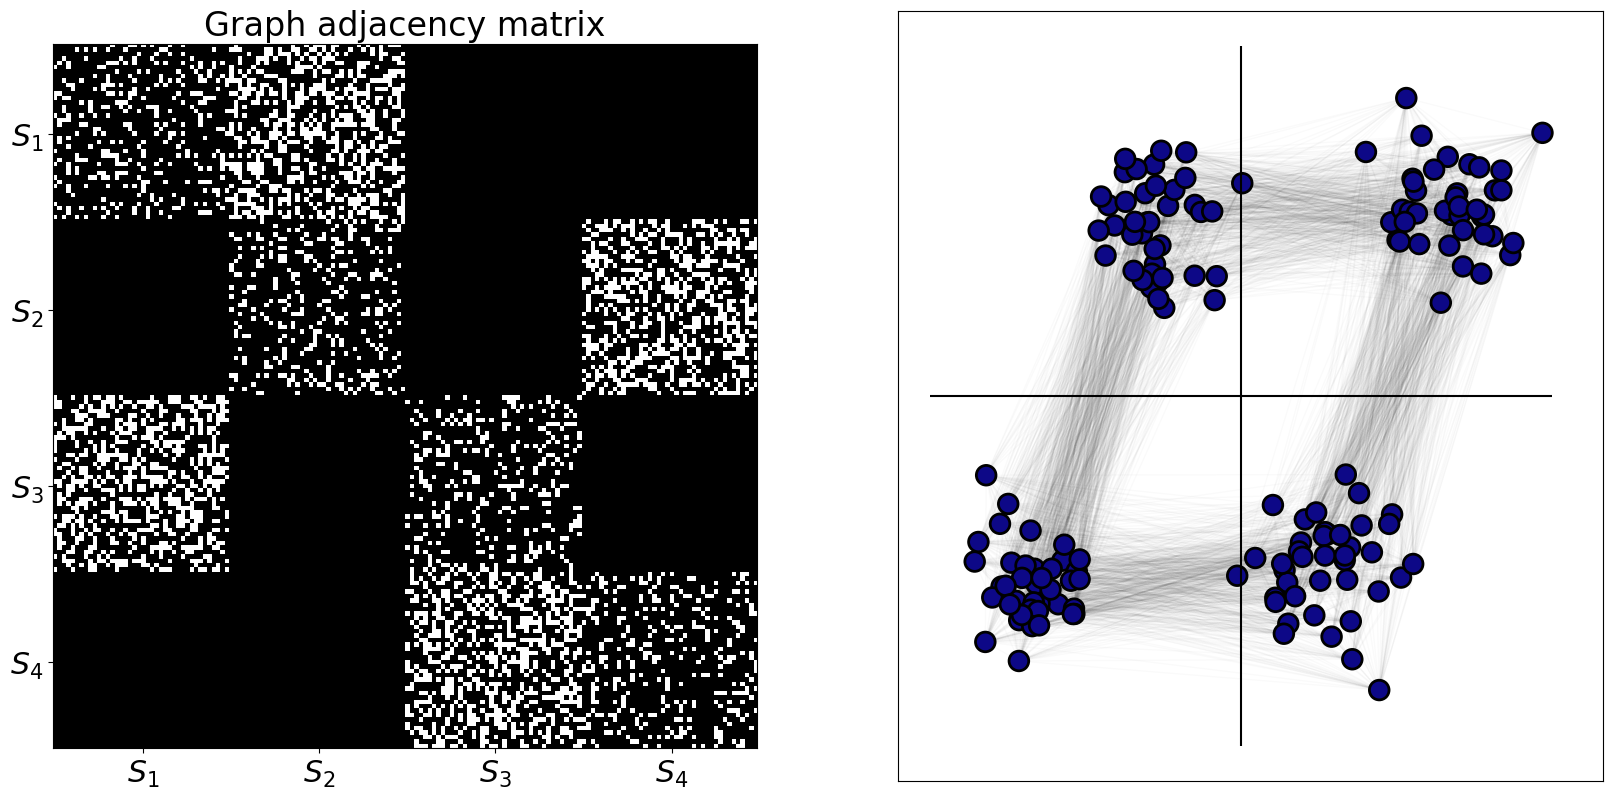

In [5]:
importlib.reload(plot)

n_per_com = 40
density_value = .4
density_con = .4
eig_id = 0

write_s = True
for_overleaf = True

seed = 28

# # NEW GRAPH
# density_value = .5
# seed = 33

# Building the graph
graph = dgsp_graphs.toy_n_communities(n_per_com, 4, com_density=density_value,
                                      connect_density=[density_con, density_con, 0, 
                                                       0, density_con, density_con],
                                      #connect_density=[1, 1, 0, 1, 1, 1],
                                      connect_out_prob=[1, 0, 0, 0.5, 1, 0], seed=seed)

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

plot.plot_adjacency(graph, ax=axes[0], use_cmap=False)
#plot.plot_graph_embedding(graph, ax=axes[1], vector_id=0, directed_edges=False, use_cmap=False)
bimod_proj(graph, ax=axes[1], vector_id=0, directed_edges=False)

axes[1].hlines(0, -0.15, 0.15, color="k")
axes[1].vlines(0, -0.15, 0.15, color="k")

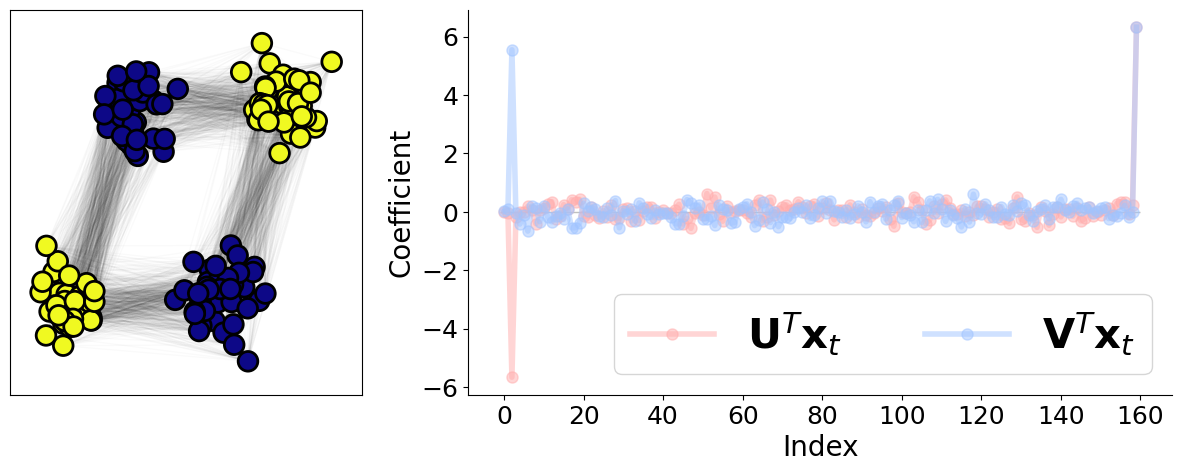

In [6]:
importlib.reload(dgsp)

vec_id = 0
U, S, Vh = dgsp.sorted_SVD(dgsp.modularity_matrix(graph, null_model="outin"))
V = Vh.T

graph_pos = {i: (U[i, vec_id], V[i, vec_id]) for i in range(len(S))}

fig, axes = plt.subplots(ncols=2, figsize=(15, 5), gridspec_kw={"width_ratios": [1, 2]})

x0 = np.zeros(len(S))
xt = x0.copy()

xt = np.random.normal(0, 0.1, len(x0))
xt = np.zeros(len(x0))
xt[:n_per_com] += 1
# xt[:n_per_com//2] += 1
# xt[n_per_com:2*n_per_com] += 1
xt[3*n_per_com:] += 1

#axes[1].plot(U.T @ xt, marker="o", color=palette_rgb[0], lw=4, markersize=8, alpha=0.5, label="$\\mathbf{U}^{{T}}\\mathbf{{x}}_{{t}}$")
bimod_proj(graph, axes[0], vector_id=vec_id, directed_edges=False, node_clusers=xt)

cutoff = len(V)//4
cutoff = 160

fourier = V.T @ xt
fourier[cutoff:] = 0

axes[1].plot(U.T @ xt, marker="o", color=palette_rgb[0], lw=4, markersize=8, alpha=0.5, label="$\\mathbf{U}^{{T}}\\mathbf{{x}}_{{t}}$")
axes[1].plot(V.T @ xt, marker="o", color=palette_rgb[1], lw=4, markersize=8, alpha=0.5, label="$\\mathbf{V}^{{T}}\\mathbf{{x}}_{{t}}$")

axes[1].hlines(0, xmin=-1, xmax=len(x0), color="silver", lw=1, zorder=0)

#axes[1].set_xlim(-1, 13)
axes[1].legend(ncol=3, fontsize=30)

axes[1].spines[["top", "right"]].set_visible(False)
#axes[1].set_xlim(-1, 8.9)

axes[1].set_xlabel("Index", fontsize=20)
axes[1].set_ylabel("Coefficient", fontsize=20)
axes[1].tick_params(labelsize=18)

Found 8 clusters !


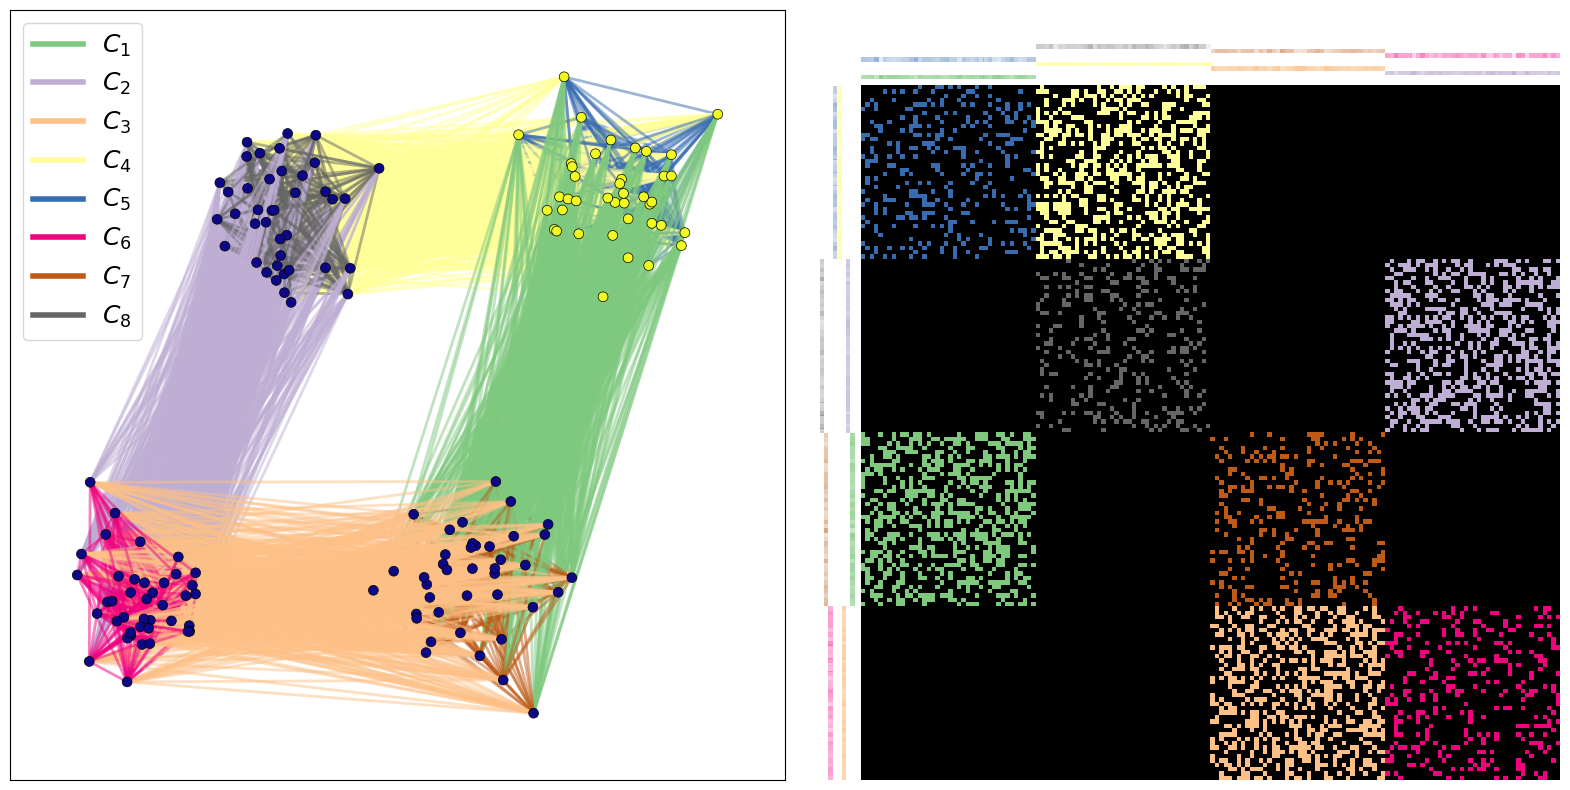

In [7]:
from matplotlib.colors import hsv_to_rgb, to_rgba
from matplotlib.lines import Line2D

xt = np.zeros(len(x0))
xt[:n_per_com] += 1
# xt[:n_per_com//2] += 1
# xt[n_per_com:2*n_per_com] += 1
# xt[3*n_per_com:] += 1

vec_id = 0
scaling = False
thresh = 0.025

n_nodes = len(S)

n_vec_max = 2
n_kmeans = 8
scale_factor = S[:n_vec_max]
edge_clusters, edge_clusters_mat = dgsp.edge_bicommunities(graph, U, V, n_vec_max, method="kmeans", n_kmeans=n_kmeans, verbose=True, max_k=10, scale_S=scale_factor)
n_clusters = np.max(edge_clusters)

c_out, c_in = dgsp.get_node_clusters(edge_clusters, edge_clusters_mat)

fig, axes = plt.subplots(ncols=2, figsize=(20, 10), gridspec_kw={"wspace": 0})

cmap_to_use = cmap_8clusters.resampled(n_kmeans+1)

axes[0].scatter(U[:, vec_id], V[:, vec_id], s=50, c=xt, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)

tab20 = plt.get_cmap("Accent")
nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[0], alpha=0.5, width=2,
                       edge_color=edge_clusters-1, edge_cmap=tab20, edge_vmin=0, edge_vmax=len(tab20.colors), arrows=False)

#legend_elements = [Line2D([0], [0], color=tab20(i-1), lw=4, alpha=1, label=f"$k={i}$") for i in np.unique(edge_clusters)]
legend_elements = [Line2D([0], [0], color=tab20(i-1), lw=4, alpha=1, label=f"$C_{{{i}}}$") for i in np.unique(edge_clusters)]

axes[0].legend(handles=legend_elements, fontsize=18, loc="upper left")

axes[1].axis("off")

cmap_accent = LinearSegmentedColormap.from_list("", ["k"] + list(tab20.colors))
cmap_accent = cmap_accent.resampled(n_kmeans+1)
axes[1].imshow(edge_clusters_mat, cmap=cmap_accent, aspect="auto", vmin=0, vmax=n_clusters)

for com_i in range(n_clusters):
    send = (edge_clusters_mat == com_i+1).sum(axis=1) > 0
    receive = (edge_clusters_mat == com_i+1).sum(axis=0) > 0

    plot_send = (np.where(send)[0].min(), np.where(send)[0].max())
    plot_receive = (np.where(receive)[0].min(), np.where(receive)[0].max())

    plot_send = np.where(send)[0]
    plot_receive = np.where(receive)[0]
    
    axes[1].scatter([-2-0.5-com_i]*len(plot_send), plot_send, marker="s", s=10, color=cmap_accent(com_i+1), edgecolors="none", alpha=c_out[com_i, plot_send])
    axes[1].scatter(plot_receive, [-2-0.5-com_i]*len(plot_receive), marker="s", s=10, color=cmap_accent(com_i+1), edgecolors="none", alpha=c_in[com_i, plot_receive])

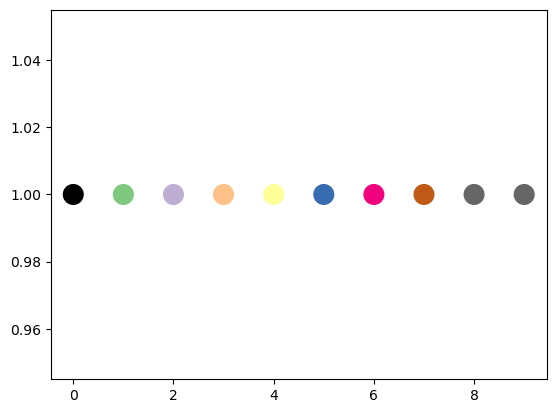

In [8]:
plt.scatter(np.arange(10), np.ones(10), c=np.arange(10), cmap=cmap_accent, s=200)

## Subset of nodes idea

Found 8 clusters !


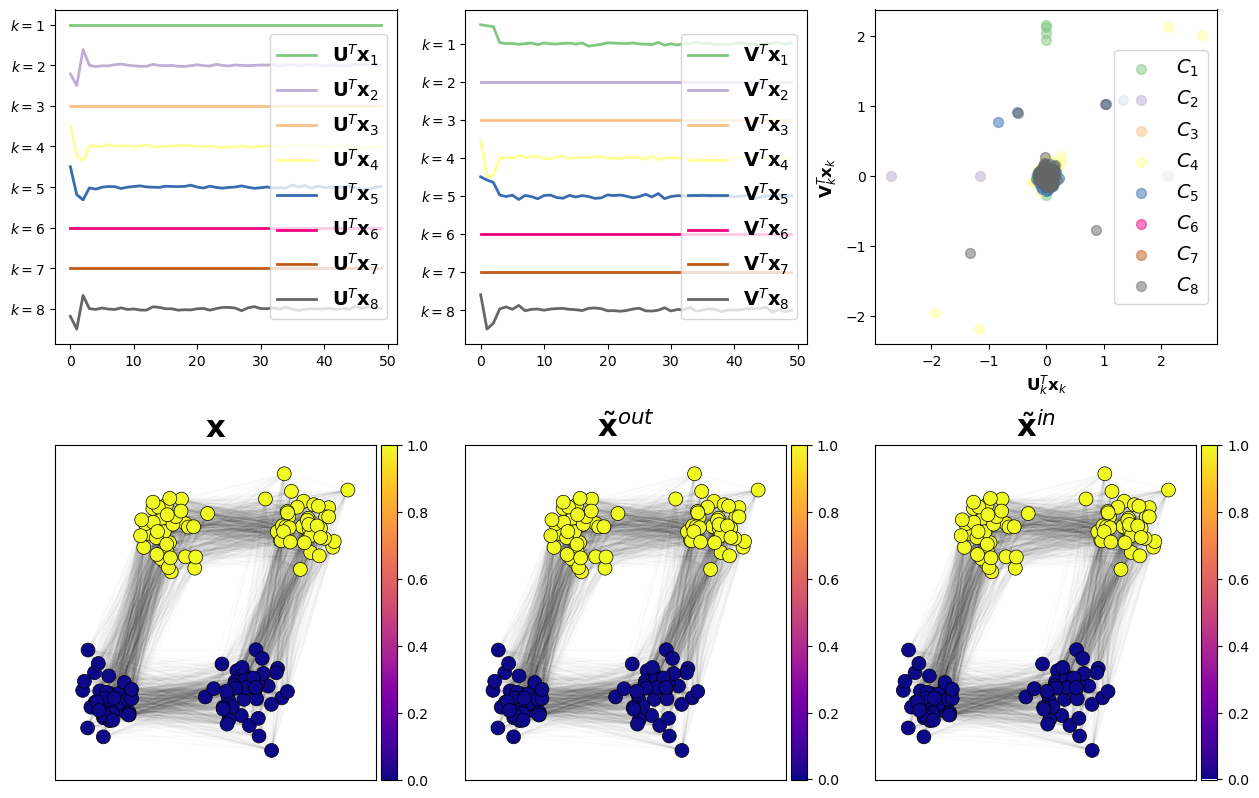

In [9]:
from matplotlib.colors import hsv_to_rgb, to_rgba

xt = np.zeros(len(x0))
xt[:n_per_com] += 1
# xt[:n_per_com//2] += 1
xt[n_per_com:2*n_per_com] += 1
# xt[3*n_per_com:] += 1

vec_id = 0
scaling = False

n_nodes = len(S)

n_vec_max = 2
n_kmeans = 8

n_comp = 50

scale_factor = S[:n_vec_max]
edge_clusters, edge_clusters_mat = dgsp.edge_bicommunities(graph, U, V, n_vec_max, method="kmeans", n_kmeans=n_kmeans, verbose=True, max_k=10, scale_S=scale_factor)
n_clusters = np.max(edge_clusters)

c_out, c_in = dgsp.get_node_clusters(edge_clusters, edge_clusters_mat)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), gridspec_kw={"hspace": 0.3})
axes = axes.flatten()

all_rec_out = np.zeros((n_clusters, n_nodes))
all_rec_in = np.zeros((n_clusters, n_nodes))

for k in range(n_clusters):
    # coef_out = U.T[:, c_out[k] > 0] @ xt[c_out[k] > 0]
    # coef_in = U.T[:, c_in[k] > 0] @ xt[c_in[k] > 0]
    
    coef_out = U.T @ (xt * c_out[k])
    coef_in = V.T @ (xt * c_in[k])

    out_max = 1
    in_max = 1
    if np.abs(coef_out).max() > 1e-10:
        out_max = np.abs(coef_out).max()
    if np.abs(coef_in).max() > 1e-10:
        in_max = np.abs(coef_in).max()

    axes[0].plot(-2*k + coef_out[:n_comp]/out_max, lw=2, color=cmap_accent(k+1),
                 label=f"$\\mathbf{{U}}^{{T}}\\mathbf{{x}}_{{{k+1}}}$")
    axes[1].plot(-2*k + coef_in[:n_comp]/in_max, lw=2, color=cmap_accent(k+1),
                 label=f"$\\mathbf{{V}}^{{T}}\\mathbf{{x}}_{{{k+1}}}$")
    
    axes[2].scatter(coef_out, coef_in, s=50, alpha=0.5, color=cmap_accent(k+1),
                     label=f"$C_{{{k+1}}}$")
    axes[2].set_xlabel("$\\mathbf{U}^{T}_{k}\\mathbf{x}_{k}$", fontsize=12)
    axes[2].set_ylabel("$\\mathbf{V}^{T}_{k}\\mathbf{x}_{k}$", fontsize=12)
    
    all_rec_out[k] = U @ coef_out
    all_rec_in[k] = V @ coef_in

    # all_rec_out[k] = all_rec_out[k] * c_out[k]
    # all_rec_in[k] = all_rec_in[k] * c_in[k]

axes[0].set_yticks(np.arange(-2*(n_clusters-1), 1, 2), labels=[f"$k={k+1}$" for k in np.arange(n_clusters - 1, -1, -1)])
axes[1].set_yticks(np.arange(-2*(n_clusters-1), 1, 2), labels=[f"$k={k+1}$" for k in np.arange(n_clusters - 1, -1, -1)])

axes[3].set_title("$\\mathbf{{x}}$", fontsize=22)
axes[3].scatter(U[:, vec_id], V[:, vec_id], s=100, c=xt, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[3], alpha=0.02, arrows=False)
plot.add_cbar(fig, axes[3])

axes[4].set_title("$\\tilde{{\\mathbf{{x}}}}^{{out}}$", fontsize=22)
axes[4].scatter(U[:, vec_id], V[:, vec_id], s=100, c=all_rec_out.sum(axis=0), cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[4], alpha=0.02, arrows=False)
plot.add_cbar(fig, axes[4])

axes[5].set_title("$\\tilde{{\\mathbf{{x}}}}^{{in}}$", fontsize=22)
axes[5].scatter(U[:, vec_id], V[:, vec_id], s=100, c=all_rec_in.sum(axis=0), cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[5], alpha=0.02, arrows=False)
plot.add_cbar(fig, axes[5])

for ax in axes[:3]:
    ax.legend(ncols=1, fontsize=14, loc="center right")

Found 8 clusters !


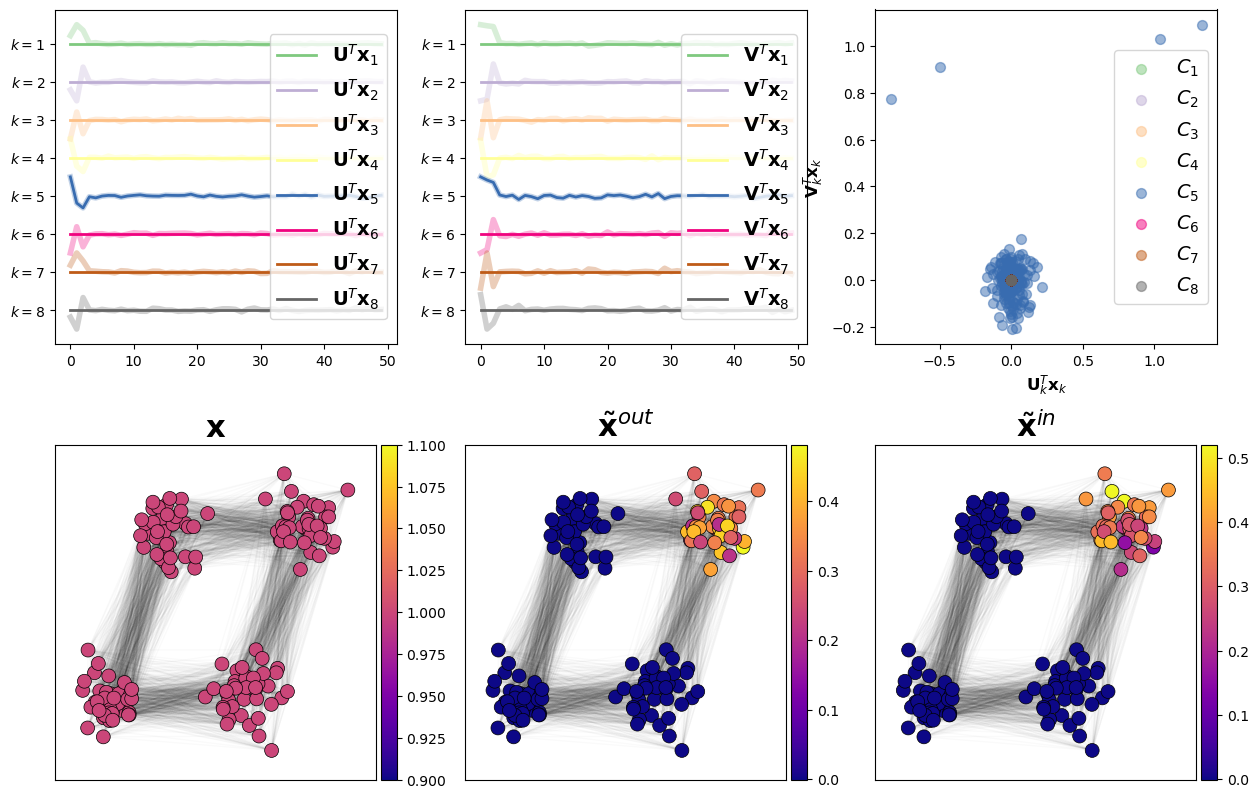

In [28]:
from matplotlib.colors import hsv_to_rgb, to_rgba

xt = np.zeros(len(x0))
xt[:n_per_com] += 1
# xt[:n_per_com//2] += 1
xt[n_per_com:2*n_per_com] += 1
# xt[3*n_per_com:] += 1
xt = np.ones(len(x0))

vec_id = 0
scaling = False
thresh = 0.025

n_nodes = len(S)

n_vec_max = 2
n_kmeans = 8
scale_factor = S[:n_vec_max]
edge_clusters, edge_clusters_mat = dgsp.edge_bicommunities(graph, U, V, n_vec_max, method="kmeans", n_kmeans=n_kmeans, verbose=True, max_k=10, scale_S=scale_factor)
n_clusters = np.max(edge_clusters)

c_out, c_in = dgsp.get_node_clusters(edge_clusters, edge_clusters_mat)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), gridspec_kw={"hspace": 0.3})
axes = axes.flatten()

all_rec_out = np.zeros((n_clusters, n_nodes))
all_rec_in = np.zeros((n_clusters, n_nodes))

for k in range(n_clusters):
    coef_out = U.T @ (xt * c_out[k])
    coef_in = V.T @ (xt * c_in[k])

    out_max = 1
    in_max = 1
    if np.abs(coef_out).max() > 1e-10:
        out_max = np.abs(coef_out).max()
    if np.abs(coef_in).max() > 1e-10:
        in_max = np.abs(coef_in).max()

    # Raw spectrum
    axes[0].plot(-2*k + coef_out[:n_comp]/out_max, lw=4, alpha=0.3, color=cmap_accent(k+1))
    axes[1].plot(-2*k + coef_in[:n_comp]/in_max, lw=4, alpha=0.3, color=cmap_accent(k+1))

    #if k not in [3]:
    if k != 4:
        coef_out[:] = 0
        coef_in[:] = 0

    # Filtered spectrum
    axes[0].plot(-2*k + coef_out[:n_comp]/out_max, lw=2, color=cmap_accent(k+1),
                 label=f"$\\mathbf{{U}}^{{T}}\\mathbf{{x}}_{{{k+1}}}$")
    axes[1].plot(-2*k + coef_in[:n_comp]/in_max, lw=2, color=cmap_accent(k+1),
                 label=f"$\\mathbf{{V}}^{{T}}\\mathbf{{x}}_{{{k+1}}}$")
    
    axes[2].scatter(coef_out, coef_in, s=50, alpha=0.5, color=cmap_accent(k+1),
                     label=f"$C_{{{k+1}}}$")
    # axes[2].plot(coef_out, coef_in, alpha=0.5, color=cmap_accent(k+1))
    axes[2].set_xlabel("$\\mathbf{U}^{T}_{k}\\mathbf{x}_{k}$", fontsize=12)
    axes[2].set_ylabel("$\\mathbf{V}^{T}_{k}\\mathbf{x}_{k}$", fontsize=12)
    
    all_rec_out[k] = U @ coef_out
    all_rec_in[k] = V @ coef_in

    # all_rec_out[k] = all_rec_out[k] * c_out[k]
    # all_rec_in[k] = all_rec_in[k] * c_in[k]

axes[0].set_yticks(np.arange(-2*(n_clusters-1), 1, 2), labels=[f"$k={k+1}$" for k in np.arange(n_clusters - 1, -1, -1)])
axes[1].set_yticks(np.arange(-2*(n_clusters-1), 1, 2), labels=[f"$k={k+1}$" for k in np.arange(n_clusters - 1, -1, -1)])

axes[3].set_title("$\\mathbf{{x}}$", fontsize=22)
axes[3].scatter(U[:, vec_id], V[:, vec_id], s=100, c=xt, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[3], alpha=0.02, arrows=False)
plot.add_cbar(fig, axes[3])

axes[4].set_title("$\\tilde{{\\mathbf{{x}}}}^{{out}}$", fontsize=22)
axes[4].scatter(U[:, vec_id], V[:, vec_id], s=100, c=all_rec_out.sum(axis=0), cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[4], alpha=0.02, arrows=False)
plot.add_cbar(fig, axes[4])

axes[5].set_title("$\\tilde{{\\mathbf{{x}}}}^{{in}}$", fontsize=22)
axes[5].scatter(U[:, vec_id], V[:, vec_id], s=100, c=all_rec_in.sum(axis=0), cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[5], alpha=0.02, arrows=False)
plot.add_cbar(fig, axes[5])

for ax in axes[:3]:
    ax.legend(ncols=1, fontsize=14, loc="center right")

Found 8 clusters !


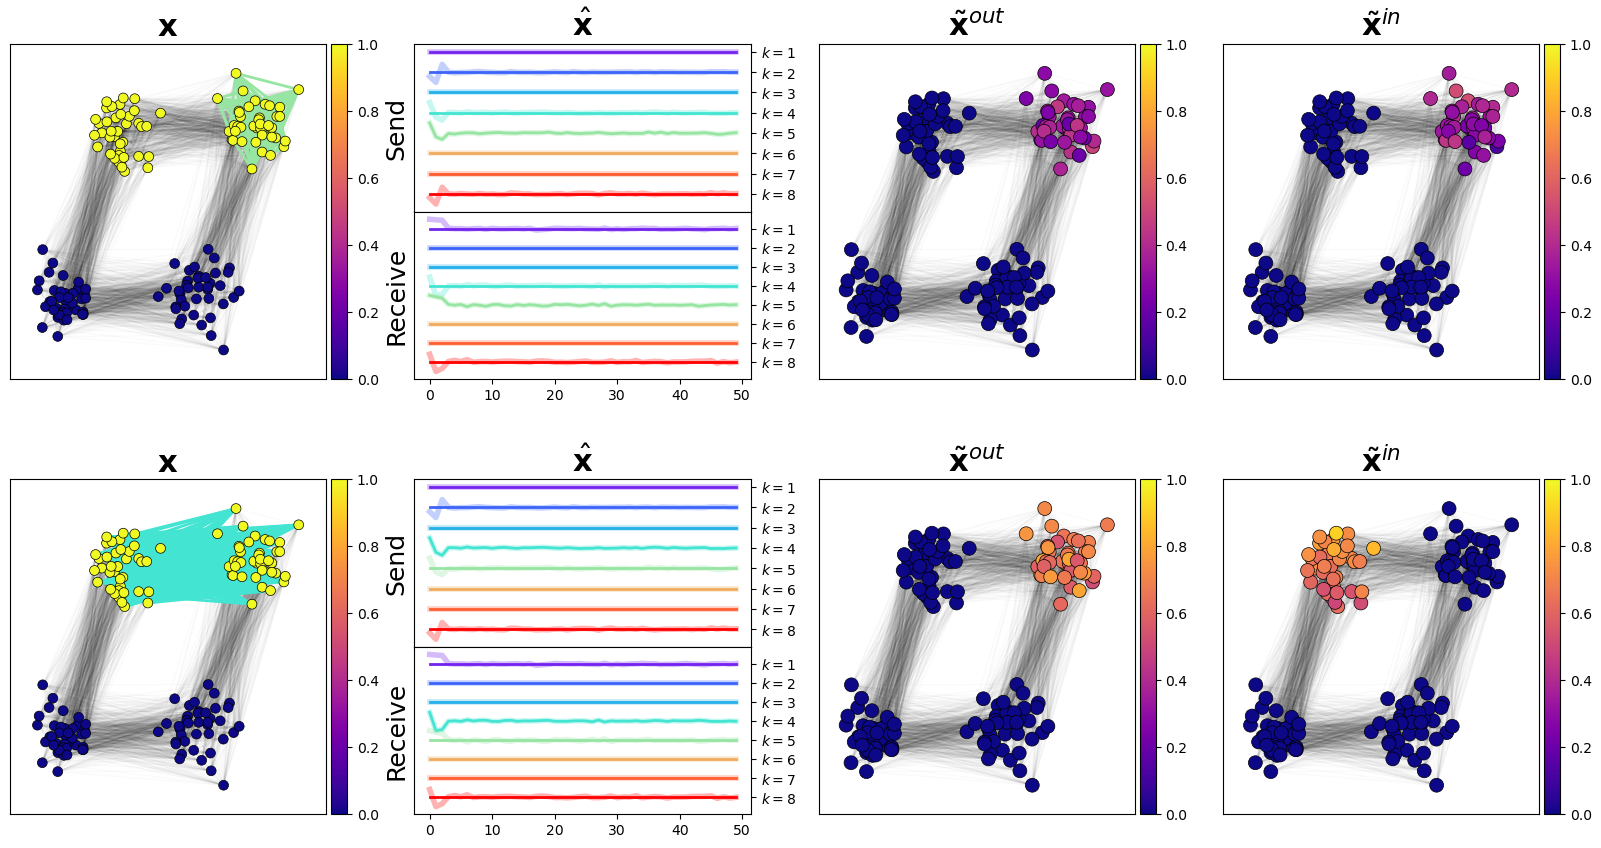

In [46]:
from matplotlib.colors import hsv_to_rgb, to_rgba

xt = np.zeros(len(x0))
xt[:n_per_com] += 1
# xt[:n_per_com//2] += 1
xt[n_per_com:2*n_per_com] += 1
# xt[3*n_per_com:] += 1
# xt = np.ones(len(x0))

vec_id = 0
scaling = False
thresh = 0.025

n_nodes = len(S)

n_vec_max = 2
n_kmeans = 8
scale_factor = S[:n_vec_max]
edge_clusters, edge_clusters_mat = dgsp.edge_bicommunities(graph, U, V, n_vec_max, method="kmeans", n_kmeans=n_kmeans, verbose=True, max_k=10, scale_S=scale_factor)
n_clusters = np.max(edge_clusters)

c_out, c_in = dgsp.get_node_clusters(edge_clusters, edge_clusters_mat)

cmap_accent = cmap_8clusters.resampled(n_kmeans+1)

graph_pos = {i: (U[i, vec_id], V[i, vec_id]) for i in range(len(S))}

all_c_ids = [4, 3]

fig, axes = plt.subplots(nrows=len(all_c_ids), ncols=4, figsize=(20, 5*len(all_c_ids)), gridspec_kw={"hspace": 0.3})

axes = np.atleast_2d(axes)

all_rec_out = np.zeros((n_clusters, n_nodes))
all_rec_in = np.zeros((n_clusters, n_nodes))

for fltr_i, c_id in enumerate(all_c_ids):
    axes[fltr_i, 0].set_title("$\\mathbf{{x}}$", fontsize=22)
    axes[fltr_i, 0].scatter(U[:, vec_id], V[:, vec_id], s=50, c=xt, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
    plot.add_cbar(fig, axes[fltr_i, 0])

    nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[fltr_i, 0], alpha=0.02, arrows=False)
    node_fltr = ((edge_clusters_mat == c_id+1).sum(axis=0) + (edge_clusters_mat == c_id+1).sum(axis=1) > 0)
    graph_fltr = edge_clusters_mat[node_fltr][:, node_fltr]
    graph_fltr[graph_fltr != c_id+1] = 0
    
    graph_pos_red = {i: (U[node_fltr][i, vec_id], V[node_fltr][i, vec_id]) for i in range(sum(node_fltr))}
    nx.draw_networkx_edges(nx.DiGraph(graph_fltr), pos=graph_pos_red, ax=axes[fltr_i, 0], alpha=1, width=2, edge_color=cmap_accent(c_id+1), arrows=False)

    axes[fltr_i, 1].axis("off")
    gs = GridSpecFromSubplotSpec(2, 1, subplot_spec=axes[fltr_i, 1], hspace=0)
    axes_spectrum = [fig.add_subplot(gs[i]) for i in range(2)]

    axes_spectrum[0].set_title("$\\hat{{\\mathbf{{x}}}}$", fontsize=22)
    for lab, ax in zip(["Send", "Receive"], axes_spectrum):
        ax.set_yticks(np.arange(-2*(n_clusters-1), 1, 2), labels=[f"$k={k+1}$" for k in np.arange(n_clusters - 1, -1, -1)])
        ax.set_ylabel(lab, fontsize=18)
        ax.yaxis.tick_right()

    for k in range(n_clusters):
        coef_out = U.T @ (xt * c_out[k])
        coef_in = V.T @ (xt * c_in[k])

        out_max = 1
        in_max = 1
        if np.abs(coef_out).max() > 1e-10:
            out_max = np.abs(coef_out).max()
        if np.abs(coef_in).max() > 1e-10:
            in_max = np.abs(coef_in).max()

        # Raw spectrum
        axes_spectrum[0].plot(-2*k + coef_out[:n_comp]/out_max, lw=4, alpha=0.3, color=cmap_accent(k+1))
        axes_spectrum[1].plot(-2*k + coef_in[:n_comp]/in_max, lw=4, alpha=0.3, color=cmap_accent(k+1))

        #if k not in [3]:
        if k != c_id:
            coef_out[:] = 0
            coef_in[:] = 0

        # Filtered spectrum
        axes_spectrum[0].plot(-2*k + coef_out[:n_comp]/out_max, lw=2, color=cmap_accent(k+1),
                    label=f"$\\mathbf{{U}}^{{T}}\\mathbf{{x}}_{{{k+1}}}$")
        axes_spectrum[1].plot(-2*k + coef_in[:n_comp]/in_max, lw=2, color=cmap_accent(k+1),
                    label=f"$\\mathbf{{V}}^{{T}}\\mathbf{{x}}_{{{k+1}}}$")
        
        all_rec_out[k] = U @ coef_out
        all_rec_in[k] = V @ coef_in

    axes[fltr_i, 2].set_title("$\\tilde{{\\mathbf{{x}}}}^{{out}}$", fontsize=22)
    axes[fltr_i, 2].scatter(U[:, vec_id], V[:, vec_id], s=100, c=all_rec_out.sum(axis=0), vmax=1, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
    nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[fltr_i, 2], alpha=0.02, arrows=False)
    plot.add_cbar(fig, axes[fltr_i, 2])

    axes[fltr_i, 3].set_title("$\\tilde{{\\mathbf{{x}}}}^{{in}}$", fontsize=22)
    axes[fltr_i, 3].scatter(U[:, vec_id], V[:, vec_id], s=100, c=all_rec_in.sum(axis=0), vmax=1, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
    nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[fltr_i, 3], alpha=0.02, arrows=False)
    plot.add_cbar(fig, axes[fltr_i, 3])

## Projection of node signal on edge space

Found 8 clusters !


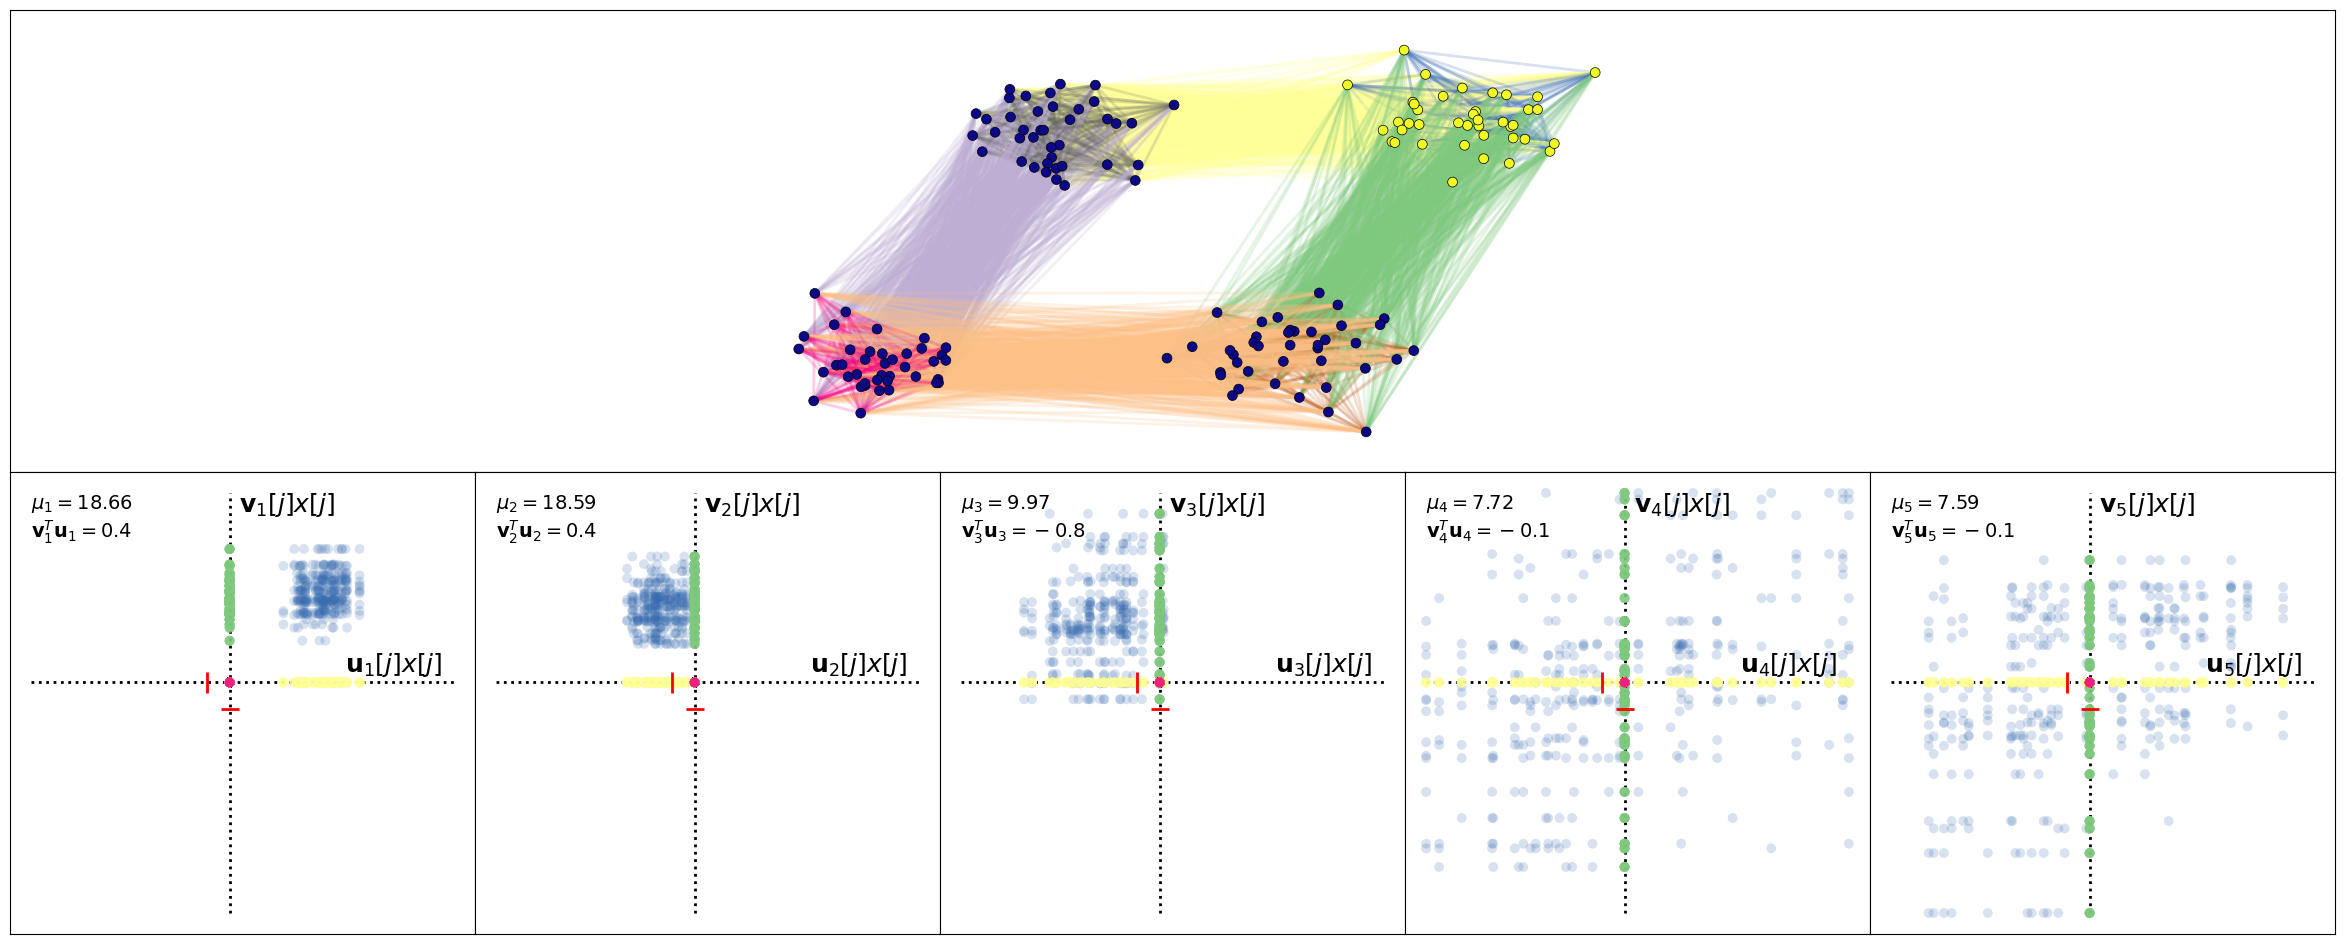

In [6]:
from matplotlib.colors import hsv_to_rgb, to_rgba

xt = np.zeros(len(x0))
xt[:n_per_com] += 1
# xt[:n_per_com//2] += 1
# xt[n_per_com:2*n_per_com] += 1
# xt[3*n_per_com:] += 1

vec_id = 0
scaling = False
thresh = 0.025

n_nodes = len(S)

n_vec_max = 2
n_kmeans = 8
scale_factor = S[:n_vec_max]
edge_clusters, edge_clusters_mat = dgsp.edge_bicommunities(graph, U, V, n_vec_max, method="kmeans", n_kmeans=n_kmeans, verbose=True, max_k=10, scale_S=scale_factor)
n_clusters = np.max(edge_clusters)

c_out, c_in = dgsp.get_node_clusters(edge_clusters, edge_clusters_mat, scale=True)

edges_id = np.array(np.where(graph != 0))

n_edges = len(edges_id[0])

edge_sending = U[edges_id[0]] * np.array([xt[edges_id[0]]]*n_nodes).T
edge_receiving = V[edges_id[1]] * np.array([xt[edges_id[1]]]*n_nodes).T

if scaling:
    edge_sending = edge_sending * S
    edge_receiving = edge_receiving * S

n_comp = 5
# fig, axes = plt.subplots(nrows=3, figsize=((n_comp+1)*5, 15), sharex=True, sharey=True, gridspec_kw={"wspace": 0, "hspace":0})
fig, axes = plt.subplots(nrows=2, figsize=((n_comp+1)*5, 12), sharex=True, sharey=True, gridspec_kw={"wspace": 0, "hspace":0})

cmap_to_use = cmap_8clusters.resampled(n_kmeans+1)

axes[0].scatter(U[:, vec_id], V[:, vec_id], s=50, c=xt, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)

tab20 = plt.get_cmap("Accent")
#nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[0], alpha=0.2, width=2, edge_color=edge_clusters, edge_cmap=cmap_to_use, edge_vmin=0, edge_vmax=n_kmeans+1, arrows=False)
nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[0], alpha=0.2, width=2, edge_color=edge_clusters-1, edge_cmap=tab20, edge_vmin=0, edge_vmax=len(tab20.colors), arrows=False)

axes[0].set_xlim(-0.4, 0.4)

gs = GridSpecFromSubplotSpec(1, n_comp, subplot_spec=axes[1], wspace=0, hspace=0)
all_axes = [fig.add_subplot(gs[i]) for i in range(n_comp)]
axes[1].axis("off")

# gs = GridSpecFromSubplotSpec(1, n_comp, subplot_spec=axes[2], wspace=0, hspace=0)
# all_axes2 = [fig.add_subplot(gs[i]) for i in range(n_comp)]
# axes[2].axis("off")

for ax_i, ax in enumerate(all_axes):
    ax.scatter(edge_sending[:, ax_i], edge_receiving[:, ax_i], s=50, alpha=0.2, edgecolor="none",
               c=edge_clusters-1, cmap=tab20, vmin=0, vmax=len(tab20.colors))
    
    ax.hlines(0, xmin=edge_sending[:, :n_comp].min(), xmax=edge_sending[:, :n_comp].max(), ls=":", color="k", lw=2, zorder=0)
    ax.vlines(0, ymin=edge_receiving[:, :n_comp].min(), ymax=edge_receiving[:, :n_comp].max(), ls=":", color="k", lw=2, zorder=0)
    
    ax.hlines(-thresh, xmin=-0.01, xmax=0.01, color="r", lw=2, zorder=5)
    ax.vlines(-thresh, ymin=-0.01, ymax=0.01, color="r", lw=2, zorder=5)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.text(0.95 * edge_sending[:, :n_comp].max(), 0.01, f"$\\mathbf{{u}}_{{{ax_i+1}}}[j]x[j]$", ha="right", fontsize=18)
    ax.text(0.01, 0.9 * edge_receiving[:, :n_comp].max(), f"$\\mathbf{{v}}_{{{ax_i+1}}}[j]x[j]$", fontsize=18)
    
    ax.text(edge_sending[:, :n_comp].min(), edge_receiving[:, :n_comp].max(), f"$\\mu_{{{ax_i+1}}}={S[ax_i]:1.2f}$\n$\\mathbf{{v}}_{{{ax_i+1}}}^T\\mathbf{{u}}_{{{ax_i+1}}}={(Vh @ U)[ax_i, ax_i]:1.1f}$", va="top", fontsize=14)
    
    # angles = np.arctan2(edge_sending[:, ax_i], edge_receiving[:, ax_i])

    # angles_prop = angles/(2*np.pi)
    # angles_prop[angles_prop < 0] = 1+angles_prop[angles_prop < 0]
    
    # angles_prop = (angles - angles.min())/(angles.max() - angles.min())

    # percent_radius = 1
    # # radius = np.sqrt(edge_sending[:, ax_i]**2 + edge_receiving[:, ax_i]**2)
    # radius = (edge_sending[:, ax_i]**2 + edge_receiving[:, ax_i]**2)
    # radius = np.clip(radius/(radius.max()*percent_radius), a_min=0, a_max=1)

    # by_radius = np.argsort(radius)

    # # edge_colors = [to_rgba(hsv_to_rgb([a, r, 1]), r) for a, r in zip(angles_prop, radius)]
    # edge_colors = [hsv_to_rgb([a, r, 1]) for a, r in zip(angles_prop, radius)]

    # all_axes2[ax_i].scatter(U[:, vec_id], V[:, vec_id], s=50, c=xt, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
    # nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=all_axes2[ax_i], alpha=radius, width=2, edge_color=edge_colors, arrows=False)
    
    # all_axes2[ax_i].set_xlim(0.05, 0.15)
    # all_axes2[ax_i].set_ylim(0.02, 0.15)

True
False


(<Figure size 2000x500 with 7 Axes>,
 <Axes: title={'center': '$\\frac{{1}}{{2}}(\\tilde{{x}}^{{out}}+\\tilde{{x}}^{{in}})$'}>)

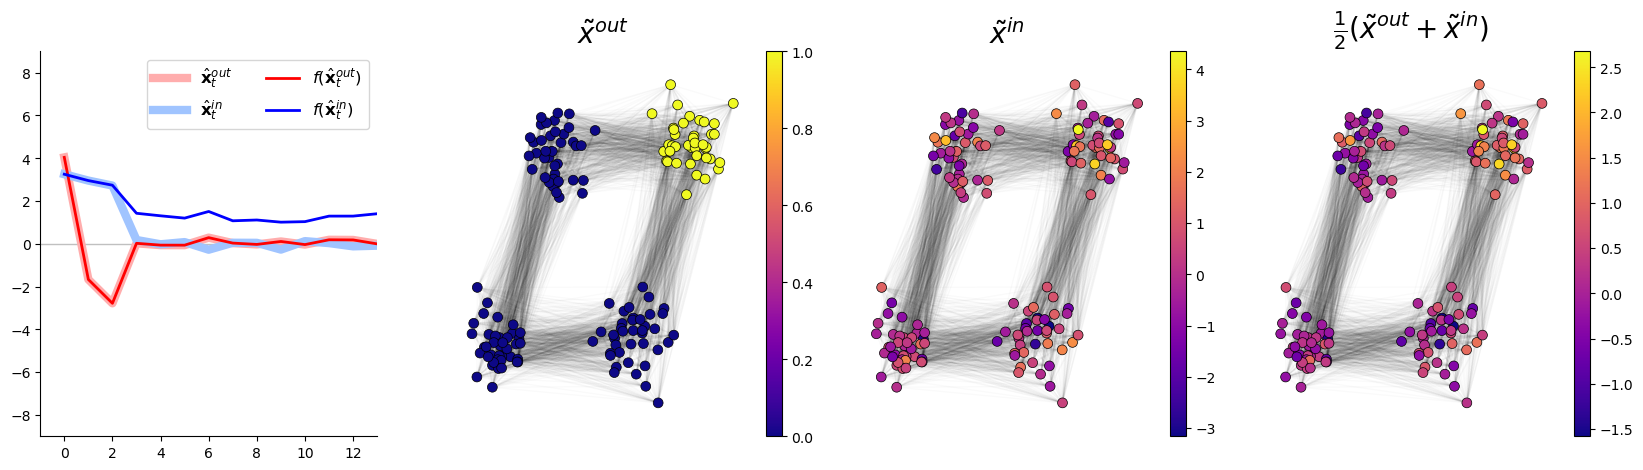

In [68]:
mix_out = np.zeros((n_nodes, n_edges))
mix_in = np.zeros((n_nodes, n_edges))

mix_out[edges_id[0], np.arange(n_edges)] = 1
mix_in[edges_id[1], np.arange(n_edges)] = 1

edge_send_mat = mix_out.T @ U
edge_send_mat = edge_send_mat * np.atleast_2d(mix_out.T @ xt).T

edge_receive_mat = mix_in.T @ V
edge_receive_mat = edge_receive_mat * np.atleast_2d(mix_in.T @ xt).T

e_send_fltr = edge_send_mat.copy()
e_receive_fltr = edge_receive_mat.copy()

## Filtering
# e_send_fltr[e_send_fltr[:, 0] < 0] = 0
# e_receive_fltr[e_receive_fltr[:, 0] < 0] = 0

# e_send_fltr[e_send_fltr < 0] = 0
e_receive_fltr[e_receive_fltr < 0] = 0
# e_receive_fltr[e_send_fltr[:, 0] < 0] = 0
# e_receive_fltr[e_receive_fltr[:, 0] < 0]

mix_out_norm = np.diag(1 / mix_out.sum(axis=1)) @ mix_out
mix_in_norm = np.diag(1 / mix_in.sum(axis=1)) @ mix_in

u_coefs = (mix_out_norm @ e_send_fltr).sum(axis=0)
v_coefs = (mix_in_norm @ e_receive_fltr).sum(axis=0)

print(np.allclose(U.T @ xt, u_coefs))
print(np.allclose(V.T @ xt, v_coefs))

fig, axes = plt.subplots(ncols=4, figsize=(20, 5))

axes[0].plot(U.T @ xt, color=palette_rgb[0], lw=6, markersize=8, label="$\\hat{{\\mathbf{{x}}}}_{{t}}^{{out}}$")
axes[0].plot(V.T @ xt, color=palette_rgb[1], lw=6, markersize=8, label="$\\hat{{\\mathbf{{x}}}}_{{t}}^{{in}}$")

axes[0].plot(u_coefs, color="r", lw=2, markersize=8, label="$f(\\hat{{\\mathbf{{x}}}}_{{t}}^{{out}})$")
axes[0].plot(v_coefs, color="b", lw=2, markersize=8, label="$f(\\hat{{\\mathbf{{x}}}}_{{t}}^{{in}})$")

axes[0].hlines(0, xmin=-1, xmax=len(x0), color="silver", lw=1, zorder=0)

axes[0].set_xlim(-1, 13)
axes[0].set_ylim(-9, 9)
axes[0].legend(ncol=2, fontsize=12)

axes[0].spines[["top", "right"]].set_visible(False)

u_rec = U @ u_coefs
axes[1].scatter(U[:, vec_id], V[:, vec_id], s=50, c=u_rec, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
axes[1].set_title("$\\tilde{{x}}^{{out}}$", fontsize=20)
axes[1].axis("off")
nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[1], alpha=0.02, width=1, arrows=False)
plot.add_cbar(fig, axes[1])

v_rec = V @ v_coefs
axes[2].scatter(U[:, vec_id], V[:, vec_id], s=50, c=v_rec, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
axes[2].set_title("$\\tilde{{x}}^{{in}}$", fontsize=20)
axes[2].axis("off")
nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[2], alpha=0.02, width=1, arrows=False)
plot.add_cbar(fig, axes[2])

axes[3].scatter(U[:, vec_id], V[:, vec_id], s=50, c=0.5*(u_rec + v_rec), cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
axes[3].set_title("$\\frac{{1}}{{2}}(\\tilde{{x}}^{{out}}+\\tilde{{x}}^{{in}})$", fontsize=20)
axes[3].axis("off")
nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[3], alpha=0.02, width=1, arrows=False)
plot.add_cbar(fig, axes[3])

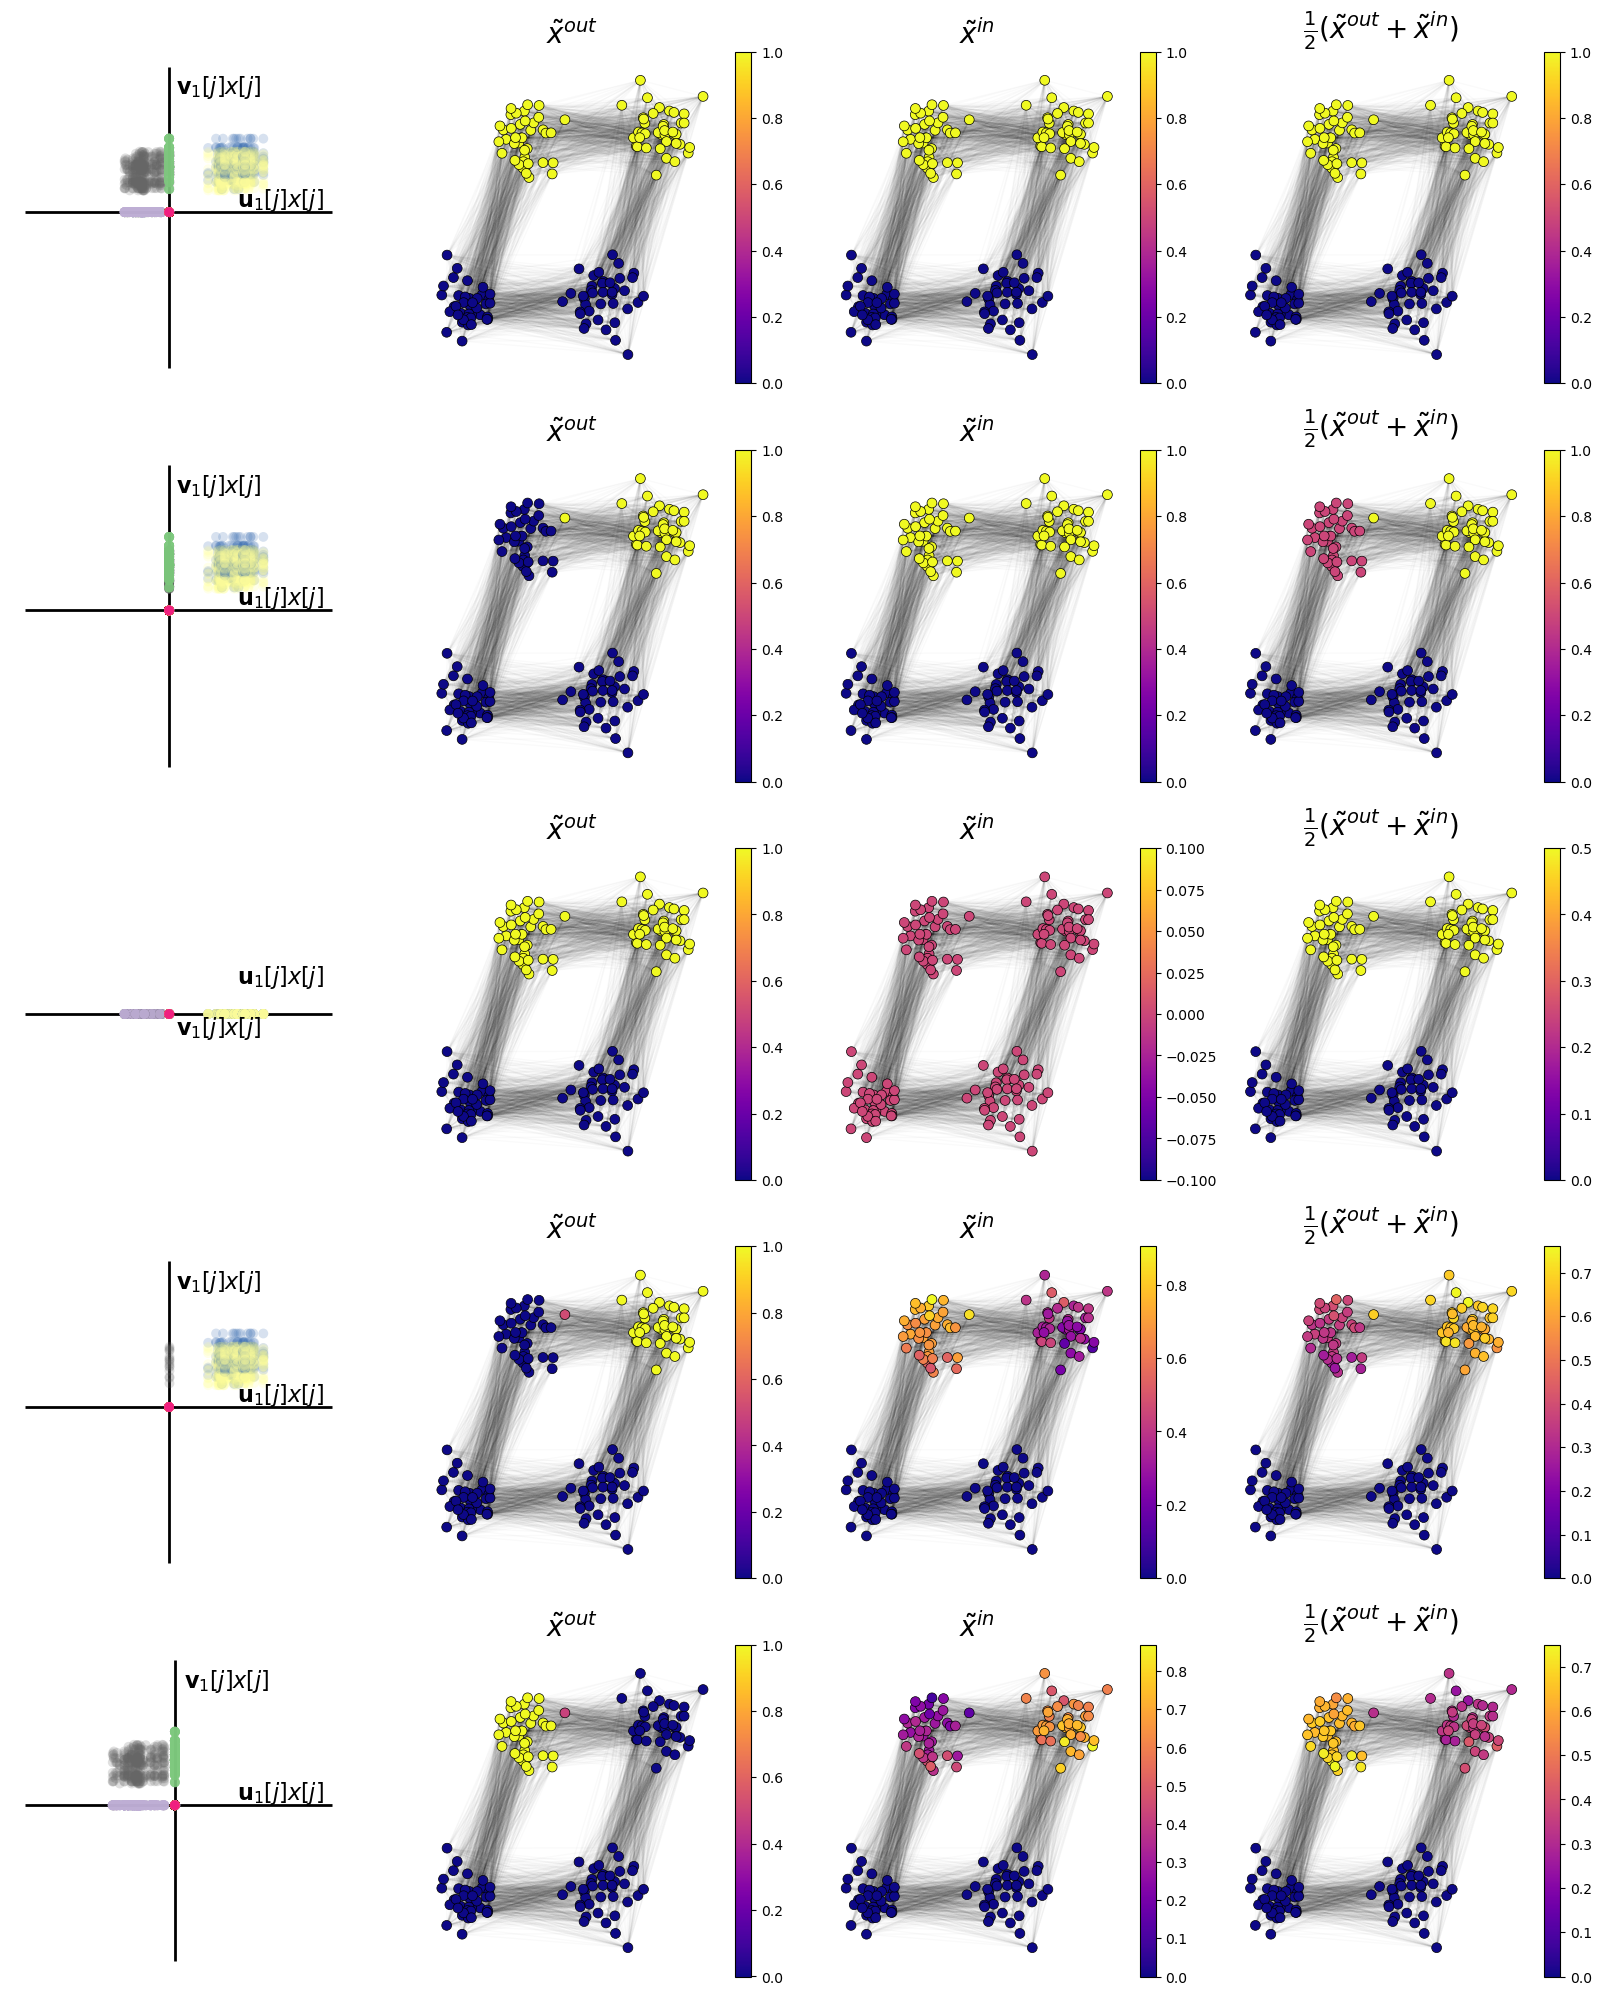

In [62]:
xt = np.zeros(len(x0))

xt[:n_per_com] += 1
# xt[:n_per_com//2] += 1
xt[n_per_com:2*n_per_com] += 1
# xt[3*n_per_com:] += 1

mix_out = np.zeros((n_nodes, n_edges))
mix_in = np.zeros((n_nodes, n_edges))

mix_out[edges_id[0], np.arange(n_edges)] = 1
mix_in[edges_id[1], np.arange(n_edges)] = 1

edge_send_mat = mix_out.T @ U
edge_send_mat = edge_send_mat * np.atleast_2d(mix_out.T @ xt).T

edge_receive_mat = mix_in.T @ V
edge_receive_mat = edge_receive_mat * np.atleast_2d(mix_in.T @ xt).T

n_filters = 5
vec_id = 0

fig, axes = plt.subplots(nrows=n_filters, ncols=4, figsize=(20, n_filters*5))

for ax_i in range(n_filters):
    e_send_fltr = edge_send_mat.copy()
    e_receive_fltr = edge_receive_mat.copy()

    ## Filtering
    if ax_i == 0:
        pass

    if ax_i == 1:
        e_send_fltr[e_send_fltr[:, 0] < 0] = 0
        e_receive_fltr[e_receive_fltr[:, 0] < 0] = 0

    if ax_i == 2:
        e_receive_fltr[:] = 0

    if ax_i == 3:
        not_self = np.logical_or(e_send_fltr[:, 0] <= 0, e_receive_fltr[:, 0] <= 0)
        e_send_fltr[not_self] = 0
        e_receive_fltr[not_self] = 0

    if ax_i == 4:
        self = np.logical_and(e_send_fltr[:, 0] > 0, e_receive_fltr[:, 0] > 0)
        e_send_fltr[self] = 0
        e_receive_fltr[self] = 0

    mix_out_norm = np.diag(1 / mix_out.sum(axis=1)) @ mix_out
    mix_in_norm = np.diag(1 / mix_in.sum(axis=1)) @ mix_in

    u_coefs = (mix_out_norm @ e_send_fltr).sum(axis=0)
    v_coefs = (mix_in_norm @ e_receive_fltr).sum(axis=0)

    axes[ax_i, 0].scatter(e_send_fltr[:, vec_id], e_receive_fltr[:, vec_id], s=50, alpha=0.2, edgecolor="none",
               c=edge_clusters-1, cmap=tab20, vmin=0, vmax=len(tab20.colors))
    
    axes[ax_i, 0].hlines(0, xmin=e_send_fltr[:, :n_comp].min(), xmax=e_send_fltr[:, :n_comp].max(), color="k", lw=2, zorder=0)
    axes[ax_i, 0].vlines(0, ymin=e_receive_fltr[:, :n_comp].min(), ymax=e_receive_fltr[:, :n_comp].max(), color="k", lw=2, zorder=0)
    
    # axes[ax_i, 0].set_xticks([])
    # axes[ax_i, 0].set_yticks([])
    axes[ax_i, 0].axis("off")

    axes[ax_i, 0].text(0.95 * e_send_fltr[:, :n_comp].max(), 0.01, f"$\\mathbf{{u}}_{{{vec_id+1}}}[j]x[j]$", ha="right", fontsize=16)
    axes[ax_i, 0].text(0.01, 0.95 * e_receive_fltr[:, :n_comp].max(), f"$\\mathbf{{v}}_{{{vec_id+1}}}[j]x[j]$", va="top", fontsize=16)

    u_rec = U @ u_coefs
    axes[ax_i, 1].scatter(U[:, vec_id], V[:, vec_id], s=50, c=u_rec, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
    axes[ax_i, 1].set_title("$\\tilde{{x}}^{{out}}$", fontsize=20)
    axes[ax_i, 1].axis("off")
    nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[ax_i, 1], alpha=0.02, width=1, arrows=False)
    plot.add_cbar(fig, axes[ax_i, 1])

    v_rec = V @ v_coefs
    axes[ax_i, 2].scatter(U[:, vec_id], V[:, vec_id], s=50, c=v_rec, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
    axes[ax_i, 2].set_title("$\\tilde{{x}}^{{in}}$", fontsize=20)
    axes[ax_i, 2].axis("off")
    nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[ax_i, 2], alpha=0.02, width=1, arrows=False)
    plot.add_cbar(fig, axes[ax_i, 2])

    axes[ax_i, 3].scatter(U[:, vec_id], V[:, vec_id], s=50, c=0.5*(u_rec + v_rec), cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
    axes[ax_i, 3].set_title("$\\frac{{1}}{{2}}(\\tilde{{x}}^{{out}}+\\tilde{{x}}^{{in}})$", fontsize=20)
    axes[ax_i, 3].axis("off")
    nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[ax_i, 3], alpha=0.02, width=1, arrows=False)
    plot.add_cbar(fig, axes[ax_i, 3])

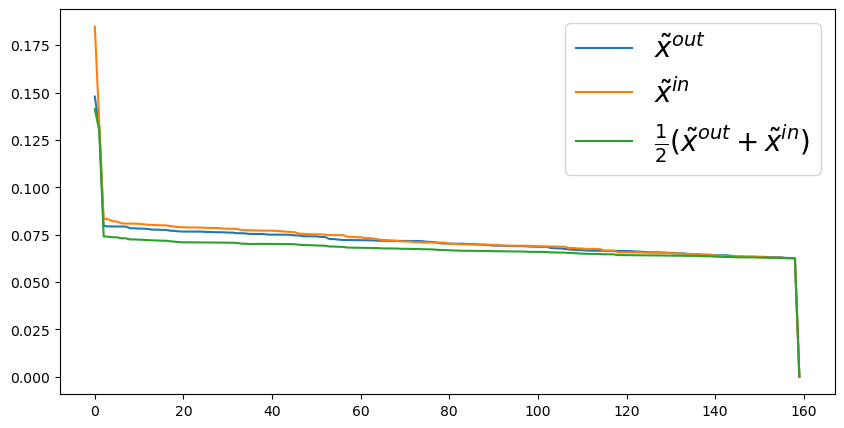

In [9]:
mix_out = np.zeros((n_nodes, n_edges))
mix_in = np.zeros((n_nodes, n_edges))

mix_out[edges_id[0], np.arange(n_edges)] = 1
mix_in[edges_id[1], np.arange(n_edges)] = 1

edge_send_mat = mix_out.T @ U
edge_send_mat = edge_send_mat * np.atleast_2d(mix_out.T @ xt).T

edge_receive_mat = mix_in.T @ V
edge_receive_mat = edge_receive_mat * np.atleast_2d(mix_in.T @ xt).T

x_one_com = xt.copy()
x_one_com[n_per_com:] = 0

n_comp = 50
n_comp = n_nodes

mses = np.zeros((n_comp, 3))
for comp_i in range(n_comp):
    ## Filtering
    e_send_fltr = edge_send_mat.copy()
    e_receive_fltr = edge_receive_mat.copy()

    e_send_fltr[e_send_fltr[:, 0] < 0, :comp_i+1] = 0
    e_receive_fltr[e_receive_fltr[:, 0] < 0, :comp_i+1] = 0

    mix_out_norm = np.diag(1 / mix_out.sum(axis=1)) @ mix_out
    mix_in_norm = np.diag(1 / mix_in.sum(axis=1)) @ mix_in

    u_coefs = (mix_out_norm @ e_send_fltr).sum(axis=0)
    v_coefs = (mix_in_norm @ e_receive_fltr).sum(axis=0)

    u_rec = U @ u_coefs
    v_rec = V @ v_coefs
    mean = 0.5*(u_rec + v_rec)

    mses[comp_i, 0] = np.mean((u_rec - x_one_com)**2)
    mses[comp_i, 1] = np.mean((v_rec - x_one_com)**2)
    mses[comp_i, 2] = np.mean((mean - x_one_com)**2)

fig, axes = plt.subplots(figsize=(10, 5))

axes.plot(mses)

recon_titles = ["$\\tilde{{x}}^{{out}}$", "$\\tilde{{x}}^{{in}}$", "$\\frac{{1}}{{2}}(\\tilde{{x}}^{{out}}+\\tilde{{x}}^{{in}})$"]
axes.legend(recon_titles, fontsize=20)

## Denoising Idea

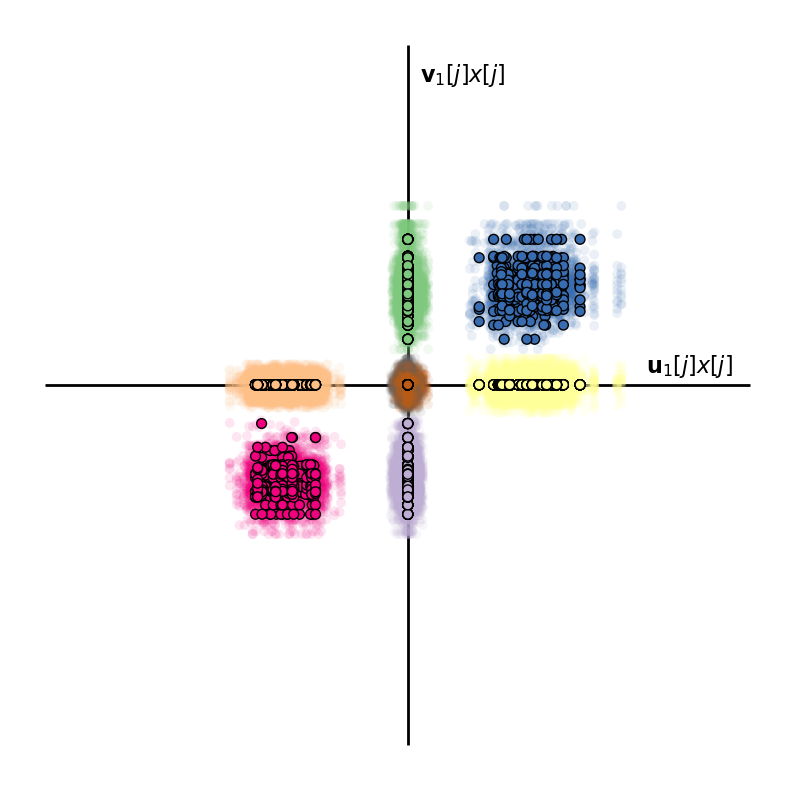

In [18]:
xt = np.zeros(len(x0))

xt[:n_per_com] += 1
# xt[:n_per_com//2] += 1
# xt[n_per_com:2*n_per_com] += 1
xt[3*n_per_com:] += 1

mix_out = np.zeros((n_nodes, n_edges))
mix_in = np.zeros((n_nodes, n_edges))

mix_out[edges_id[0], np.arange(n_edges)] = 1
mix_in[edges_id[1], np.arange(n_edges)] = 1

edge_send_mat = mix_out.T @ U
edge_send_mat = edge_send_mat * np.atleast_2d(mix_out.T @ xt).T

edge_receive_mat = mix_in.T @ V
edge_receive_mat = edge_receive_mat * np.atleast_2d(mix_in.T @ xt).T

e_send_fltr = edge_send_mat.copy()
e_receive_fltr = edge_receive_mat.copy()

fig, axes = plt.subplots(figsize=(10, 10))

mix_out_norm = np.diag(1 / mix_out.sum(axis=1)) @ mix_out
mix_in_norm = np.diag(1 / mix_in.sum(axis=1)) @ mix_in

u_coefs = (mix_out_norm @ e_send_fltr).sum(axis=0)
v_coefs = (mix_in_norm @ e_receive_fltr).sum(axis=0)

axes.scatter(e_send_fltr[:, vec_id], e_receive_fltr[:, vec_id], s=50, alpha=1, edgecolor="k",
             c=edge_clusters-1, cmap=tab20, vmin=0, vmax=len(tab20.colors))

axes.hlines(0, xmin=e_send_fltr[:, :n_comp].min(), xmax=e_send_fltr[:, :n_comp].max(), color="k", lw=2, zorder=0)
axes.vlines(0, ymin=e_receive_fltr[:, :n_comp].min(), ymax=e_receive_fltr[:, :n_comp].max(), color="k", lw=2, zorder=0)

axes.axis("off")

axes.text(0.95 * e_send_fltr[:, :n_comp].max(), 0.01, f"$\\mathbf{{u}}_{{{vec_id+1}}}[j]x[j]$", ha="right", fontsize=16)
axes.text(0.01, 0.95 * e_receive_fltr[:, :n_comp].max(), f"$\\mathbf{{v}}_{{{vec_id+1}}}[j]x[j]$", va="top", fontsize=16)

n_random = 10
for random_i in range(n_random):
    xt = np.random.normal(0, 0.1, len(x0))

    xt[:n_per_com] += 1
    # xt[:n_per_com//2] += 1
    # xt[n_per_com:2*n_per_com] += 1
    xt[3*n_per_com:] += 1

    mix_out = np.zeros((n_nodes, n_edges))
    mix_in = np.zeros((n_nodes, n_edges))

    mix_out[edges_id[0], np.arange(n_edges)] = 1
    mix_in[edges_id[1], np.arange(n_edges)] = 1

    edge_send_mat = mix_out.T @ U
    edge_send_mat = edge_send_mat * np.atleast_2d(mix_out.T @ xt).T

    edge_receive_mat = mix_in.T @ V
    edge_receive_mat = edge_receive_mat * np.atleast_2d(mix_in.T @ xt).T

    e_send_fltr = edge_send_mat.copy()
    e_receive_fltr = edge_receive_mat.copy()

    mix_out_norm = np.diag(1 / mix_out.sum(axis=1)) @ mix_out
    mix_in_norm = np.diag(1 / mix_in.sum(axis=1)) @ mix_in

    u_coefs = (mix_out_norm @ e_send_fltr).sum(axis=0)
    v_coefs = (mix_in_norm @ e_receive_fltr).sum(axis=0)

    axes.scatter(e_send_fltr[:, vec_id], e_receive_fltr[:, vec_id], s=50, alpha=0.1, edgecolor="none",
                 c=edge_clusters-1, cmap=tab20, vmin=0, vmax=len(tab20.colors), zorder=0)

(<Figure size 1500x500 with 5 Axes>,
 <Axes: title={'center': '$\\frac{{1}}{{2}}(\\tilde{{x}}^{{out}}+\\tilde{{x}}^{{in}})$'}>)

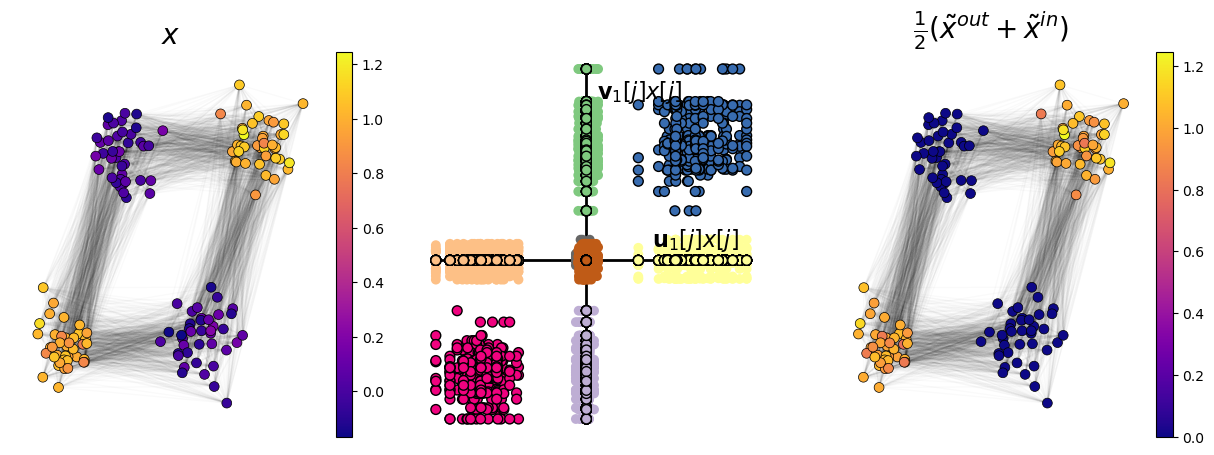

In [57]:
xt = np.random.normal(0, 0.1, len(x0))

xt[:n_per_com] += 1
# xt[:n_per_com//2] += 1
# xt[n_per_com:2*n_per_com] += 1
xt[3*n_per_com:] += 1

mix_out = np.zeros((n_nodes, n_edges))
mix_in = np.zeros((n_nodes, n_edges))

mix_out[edges_id[0], np.arange(n_edges)] = 1
mix_in[edges_id[1], np.arange(n_edges)] = 1

edge_send_mat = mix_out.T @ U
edge_send_mat = edge_send_mat * np.atleast_2d(mix_out.T @ xt).T

edge_receive_mat = mix_in.T @ V
edge_receive_mat = edge_receive_mat * np.atleast_2d(mix_in.T @ xt).T

e_send_fltr = edge_send_mat.copy()
e_receive_fltr = edge_receive_mat.copy()

# Soft threshold
thresh = 0.03
e_send_fltr[np.abs(e_send_fltr[:, 0]) < thresh] = 0
e_receive_fltr[np.abs(e_receive_fltr[:, 0]) < thresh] = 0

# Clipping
clip = 0.12
# e_send_fltr = np.clip(e_send_fltr, -clip, clip)
# e_receive_fltr = np.clip(e_receive_fltr, -clip, clip)

n_comp = 1

mix_out_norm = np.diag(1 / mix_out.sum(axis=1)) @ mix_out
mix_in_norm = np.diag(1 / mix_in.sum(axis=1)) @ mix_in

u_coefs = (mix_out_norm @ e_send_fltr).sum(axis=0)
v_coefs = (mix_in_norm @ e_receive_fltr).sum(axis=0)

denoised = 0.5*(U @ u_coefs + V @ v_coefs)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

# Signal
ax_sig = 0
axes[ax_sig].scatter(U[:, vec_id], V[:, vec_id], s=50, c=xt, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
axes[ax_sig].set_title("$x$", fontsize=20)
axes[ax_sig].axis("off")
nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[ax_sig], alpha=0.02, width=1, arrows=False)
plot.add_cbar(fig, axes[ax_sig])

# Spectrum
ax_spectrum = 1
axes[ax_spectrum].scatter(edge_send_mat[:, vec_id], edge_receive_mat[:, vec_id], s=50, alpha=1, edgecolor="none",
             c=edge_clusters-1, cmap=tab20, vmin=0, vmax=len(tab20.colors))

axes[ax_spectrum].hlines(0, xmin=edge_send_mat[:, :n_comp].min(), xmax=edge_send_mat[:, :n_comp].max(), color="k", lw=2, zorder=0)
axes[ax_spectrum].vlines(0, ymin=edge_receive_mat[:, :n_comp].min(), ymax=edge_receive_mat[:, :n_comp].max(), color="k", lw=2, zorder=0)

axes[ax_spectrum].axis("off")

axes[ax_spectrum].text(0.95 * edge_send_mat[:, :n_comp].max(), 0.01, f"$\\mathbf{{u}}_{{{vec_id+1}}}[j]x[j]$", ha="right", fontsize=16)
axes[ax_spectrum].text(0.01, 0.95 * edge_receive_mat[:, :n_comp].max(), f"$\\mathbf{{v}}_{{{vec_id+1}}}[j]x[j]$", va="top", fontsize=16)

# Modified Spectrum
axes[ax_spectrum].scatter(e_send_fltr[:, vec_id], e_receive_fltr[:, vec_id], s=50, alpha=1, edgecolor="k",
             c=edge_clusters-1, cmap=tab20, vmin=0, vmax=len(tab20.colors))

# Denoised signal
ax_den = 2
axes[ax_den].scatter(U[:, vec_id], V[:, vec_id], s=50, c=denoised, cmap="plasma", zorder=2, edgecolor="k", linewidth=0.5)
axes[ax_den].set_title("$\\frac{{1}}{{2}}(\\tilde{{x}}^{{out}}+\\tilde{{x}}^{{in}})$", fontsize=20)
axes[ax_den].axis("off")
nx.draw_networkx_edges(nx.DiGraph(graph), pos=graph_pos, ax=axes[ax_den], alpha=0.02, width=1, arrows=False)
plot.add_cbar(fig, axes[ax_den])